v1  
베이스 라인  

목표  
CNN 모델만들어 이미지 분류  


---
CNN 이론 이해  
텐서플로로 ㅅ구현하여 CNN의 동작과정을 이해하고자 한다  


---
데이터셋  

채소모음 https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition  
colab과 kaggle 연동하여 업로드  



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
#colab과 Kaggle 연동 및 다운로드
!pip install kaggle  
from google.colab import files  
files.upload()  
!mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/  # Kaggle.json (Kaggle API Token) upload
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list -s english-french   
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition # 참고할 Kaggle API
!unzip englishfrench-translations.zip  
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
ref                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
dhruvildave/en-fr-translation-dataset             English-French Translation Dataset                  3GB  2021-02-09 19:27:52           1288         35  1.0              
devicharith/language-translation-englishfrench    Language Translation (English-French)               4MB  2020-04-08 11:35:32           1142         31  0.8235294        
digvijayyadav/frenchenglish                       English to French translations                      6MB  2020-07-27 16:22:20            305         17  1.0              
jannesklaas/frenchenglish-bilingual-pairs         French-English Bilingual Pairs                      6MB 

In [ ]:
# zip 풀기
%cd "/content/"
!unzip -qq "/content/fruit-and-vegetable-image-recognition.zip"

/content


# 데이터셋 데이터 전처리

Image DataGenerator  
이미지를 학습시킬 때 학습데이터의 양이 적을 경우

학습데이터를 조금씩 변형시켜서 학습데이터의 양을 늘리는 방식중에 하나  

감자 이미지를 1 픽셀 옆으로 민다고 고구마 이미지가 되진 않는다.  
회전, 확대, 이동, 반전 등의 효과를 적용해도 감자는 여전히 감자이다.  
하지만 픽셀 데이터 상으로는 완전히 다른 데이터이므로 이 점을 이용해 데이터 증식과 위치이동이나 회전에 대한 학습도 진행할 수 있다

In [ ]:
train_data = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True, # 랜덤 가로 뒤짚기
                                  shear_range=True, # 랜덤으로 이미지 밀어 찌그러트리기
                                  rotation_range=30, #  -30 ~ 30도 범위 랜덤 회전
                                  zoom_range=0.3, # 랜덤 줌 범위 30%
                                  width_shift_range=0.3, # 30% 범위로 좌우 이동
                                  height_shift_range=0.3 # 30% 범위로 상하 이동
                                )

In [ ]:
train_images = train_data.flow_from_directory('/content/train',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 3115 images belonging to 36 classes.


In [ ]:
val_data = ImageDataGenerator(rescale=1/255.)

val_images = val_data.flow_from_directory('/content/validation',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 351 images belonging to 36 classes.


In [ ]:
test_data = ImageDataGenerator(rescale=1/255.)

test_images = test_data.flow_from_directory('/content/test',
                                           target_size=(64,64),
                                           batch_size=32,
                                           class_mode='categorical')

Found 359 images belonging to 36 classes.


# 모델 구성

양 비슷한 모델 긁어온거라 수정 필요

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32,activation='relu',kernel_size=(3,3),input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,activation='relu',kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,activation='relu',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,activation='relu',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=36,activation='softmax'))

컴파일

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 128)      5

In [ ]:
# model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
# model.summary();

# 훈련

In [ ]:
history = model.fit(train_images,
              epochs=100,
              batch_size=32,
              validation_data=val_images)

Epoch 1/100
 4/98 [>.............................] - ETA: 1:56 - loss: 4.5035 - accuracy: 0.0234

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 6/98 [>.............................] - ETA: 1:42 - loss: 4.4027 - accuracy: 0.0312

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


98/98 [==============================] - 158s 1s/step - loss: 3.7352 - accuracy: 0.0671 - val_loss: 3.6829 - val_accuracy: 0.0285
Epoch 2/100
98/98 [==============================] - 131s 1s/step - loss: 3.1875 - accuracy: 0.1281 - val_loss: 4.1455 - val_accuracy: 0.0285
Epoch 3/100
98/98 [==============================] - 135s 1s/step - loss: 2.9987 - accuracy: 0.1502 - val_loss: 3.7604 - val_accuracy: 0.0285
Epoch 4/100
98/98 [==============================] - 131s 1s/step - loss: 2.8516 - accuracy: 0.1689 - val_loss: 3.2435 - val_accuracy: 0.1339
Epoch 5/100
98/98 [==============================] - 131s 1s/step - loss: 2.7568 - accuracy: 0.1900 - val_loss: 2.7521 - val_accuracy: 0.1852
Epoch 6/100
98/98 [==============================] - 131s 1s/step - loss: 2.6429 - accuracy: 0.2106 - val_loss: 2.8564 - val_accuracy: 0.1909
Epoch 7/100
98/98 [==============================] - 130s 1s/step - loss: 2.6173 - accuracy: 0.2276 - val_loss: 2.9528 - val_accuracy: 0.2393
Epoch 8/100
98/98 

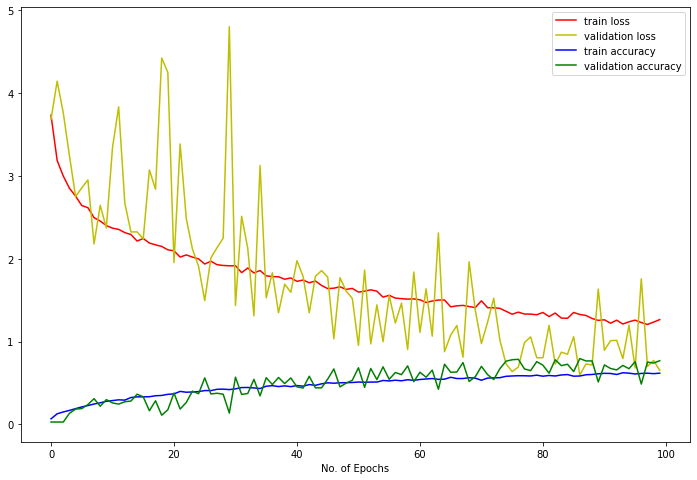

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'y',label='validation loss')
plt.plot(history.history['accuracy'],'b',label='train accuracy')
plt.plot(history.history['val_accuracy'],'g',label='validation accuracy')
plt.xlabel('Epochs')
# plt.title('')
plt.legend();

In [ ]:
model.evaluate(test_images)

12/12 [==============================] - 17s 1s/step - loss: 0.6589 - accuracy: 0.7660


[0.6589157581329346, 0.7660167217254639]

######################################################

In [ ]:
# 예측하기. 테스트 이미지에 대한 출력
predictions = model.predict(test_images)
print(predictions[0])
print(np.argmax(predictions[0]))

12/12 [==============================] - 18s 1s/step
[7.2650992e-06 1.4707667e-03 6.6992898e-06 7.4243638e-07 2.8886661e-06
 7.7594439e-07 5.4767850e-05 1.3172727e-04 4.5820778e-07 2.0067791e-05
 2.6378448e-06 4.2065058e-06 9.7837448e-03 9.6399748e-01 2.6540434e-07
 2.2290124e-06 5.2318966e-04 6.7152781e-05 3.3383617e-07 2.1859641e-04
 3.4705014e-03 7.7329050e-06 2.5228649e-06 9.2911898e-05 7.6595268e-07
 5.3772272e-04 5.5446844e-07 1.7329875e-02 3.2997364e-04 4.2972162e-05
 5.2595840e-07 3.8573555e-05 5.3960655e-04 4.3059001e-07 1.3073350e-03
 1.9908041e-06]
13
